In [167]:
sample = "LL731-P2-TC"
template = "Tigre"
data_path = "/storage/wangshouwenLab/limited_shared_folder/analysis/CARLIN/20220717_SC_3A/test/LL731-P2-TC"
output_dir = "/storage/wangshouwenLab/limited_shared_folder/analysis/CARLIN/20220717_SC_3A/test/output"
ref_dir ='/storage/wangshouwenLab/shared_folder/packages/snakemake_DARLIN/reference'
CARLIN_read_cutoff=3 # used to compare with CARLIN pipeline
cfg='scCamellia' # ['sc10xV3',  'scCamellia']
min_reads_per_allele_group=1 # the lower bound of the later read count filtering, after denoising, and re-group reads. 
distance_relative_threshold=0.03 # 5% error rate, will be multipled with the sequence length
read_ratio_threshold=0.6
seq_3prime_upper_N=12
seq_5prime_upper_N=None

In [149]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
from mosaiclineage import DARLIN as dar
from mosaiclineage import larry
import importlib
importlib.reload(dar)
importlib.reload(larry)
#%config InlineBackend.figure_format = 'svg' #'retina'         # or 'svg'
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows',20)
%matplotlib inline


if template.startswith("cCARLIN"):
    seq_5prime = dar.CA_5prime
    seq_3prime = dar.CA_3prime
    ref_DARLIN_seq = dar.CA_CARLIN
elif template.startswith("Tigre"):
    seq_5prime = dar.TA_5prime
    seq_3prime = dar.TA_3prime
    ref_DARLIN_seq = dar.TA_CARLIN
elif template.startswith("Rosa"):
    seq_5prime = dar.RA_5prime
    seq_3prime = dar.RA_3prime
    ref_DARLIN_seq = dar.RA_CARLIN
else:
    raise ValueError("template must start with {'cCARLIN','Tigre','Rosa'}")

# Single-cell CARLIN pipeline for scCamellia data

In [21]:
CARLIN_dir=data_path+f'/DARLIN/results_cutoff_override_{CARLIN_read_cutoff}'

In [22]:
ref_name=cfg
df_ref_BC=pd.read_csv(f'{ref_dir}/{ref_name}_barcodes.txt.gz',
                      sep='\t',header=None,names=['CB'],compression='gzip')

In [23]:
data_path

'/storage/wangshouwenLab/limited_shared_folder/analysis/CARLIN/20220717_SC_3A/test'

In [27]:
%%time
## load sequences
df_raw_reads=dar.CARLIN_raw_reads(data_path,sample,protocol=cfg,fastq_format=0) # format 0: _R1.fastq.gz;  format 1: _L001_R1_001.fastq.gz

154352it [00:04, 37836.62it/s]
154352it [00:01, 80204.96it/s] 


CPU times: user 19.4 s, sys: 225 ms, total: 19.6 s
Wall time: 19.7 s


In [28]:
df_N=df_raw_reads[df_raw_reads['cell_bc'].apply(lambda x: 'N' in x)]
print('N fraction:',len(df_N)/len(df_raw_reads))

N fraction: 0.03548382916969006


In [29]:
df_filter_reads=dar.CARLIN_preprocessing(df_raw_reads,template=template,ref_cell_barcodes=df_ref_BC['CB'],
                                         seq_3prime_upper_N=seq_3prime_upper_N,seq_5prime_upper_N=seq_5prime_upper_N)

Total fastq: 154352
Fastq frac. with vaid 5 prime: 0.595
Fastq frac. with vaid 3 prime: 0.487
Fastq with valid barcodes: 65444 (0.424)
Fastq frac. with vaid 3 and 5 prime: 0.424
Edited fastq fraction: 0.996


## Check raw data qualities

Check raw data to decide the read cutoff. If we see a linear slope between read number per cell and clone number per cell, this is a signature of sequencing-error induced clonal diversity

In [30]:
#df_counts=larry.extract_putative_valid_cell_id(df_filter_reads,signal_threshold=2.5,cell_key="clone_id",)

Identified 31 putative cell_id


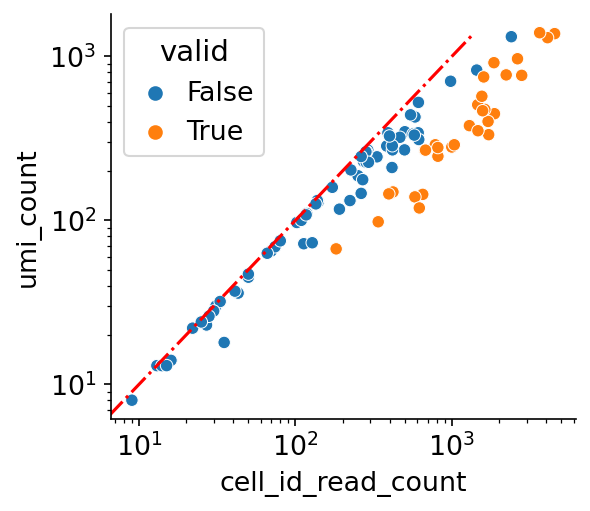

In [31]:
df_valid_cells=larry.extract_putative_valid_cell_id(df_filter_reads,signal_threshold=2,cell_key="cell_id",null_slope=1)

In [32]:
df_valid_cells

,cell_id,cell_id_read_count,umi_count,valid
1,LL731-P2-TC_AACAACCA,2794,766,True
2,LL731-P2-TC_AACCGAGA,420,149,True
4,LL731-P2-TC_AACGTGAT,1871,447,True
12,LL731-P2-TC_ACAAGCTA,395,145,True
13,LL731-P2-TC_ACACAGAA,670,268,True
...,...,...,...,...
86,LL731-P2-TC_GTGTTCTA,619,119,True
87,LL731-P2-TC_TAGGATGA,182,67,True
88,LL731-P2-TC_TATCAGCA,1036,289,True
92,LL731-P2-TC_TGGAACAA,1597,749,True


In [33]:
#df_read=larry.QC_read_per_molecule(df_filter_reads,target_keys=["umi"])

We are interested to see at what read cutoff the corresponding cell number or clone number conform to our expectation. For example, for scCamellia, we only expect around 386cells, and ~300 clones

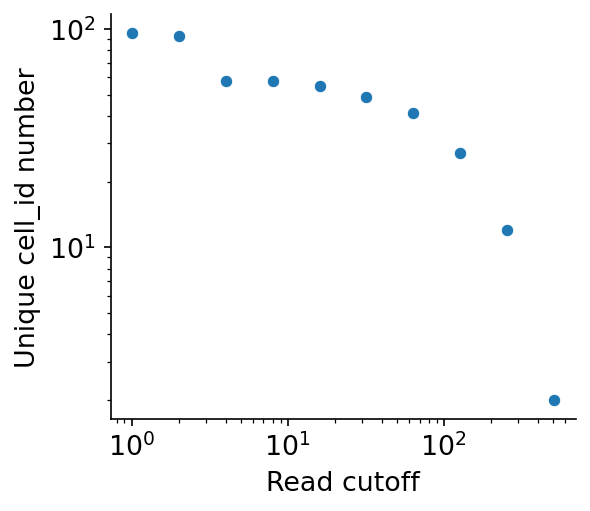

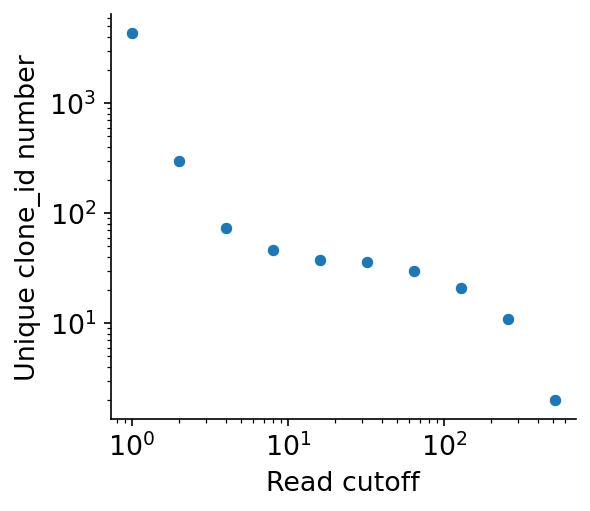

In [34]:
df_unique=larry.QC_unique_cells(df_filter_reads,target_keys=['cell_id','clone_id'])

In [35]:
larry.print_statistics(df_filter_reads)

library number: 1
cell_id number: 96
clone_id number: 4374
umi_id number: 28139
total reads: 65K


Plot distribution of unique clone barcode length. This informs how computationally expensive the following operation will be

Text(0.5, 1.0, 'Raw CARLIN length dist (UMI): 33523 count')

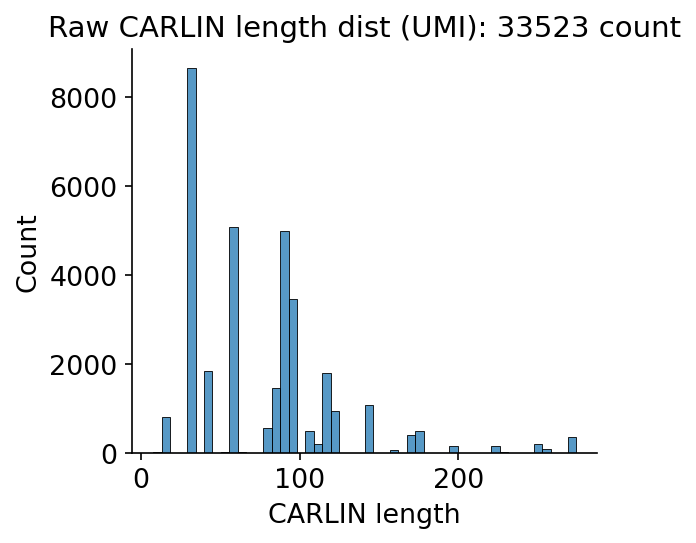

In [36]:
df_filter_reads['bc_length']=df_filter_reads['clone_id'].apply(lambda x: len(x))
unique_bc_length=df_filter_reads['bc_length'] #list(set(df_filter_reads['bc_length']))
ax=sns.histplot(unique_bc_length,bins=50)
ax.set_xlabel('CARLIN length')
ax.set_title(f'Raw CARLIN length dist (UMI): {len(unique_bc_length)} count')

Text(0.5, 1.0, 'Unique CARLIN length dist: 80 count')

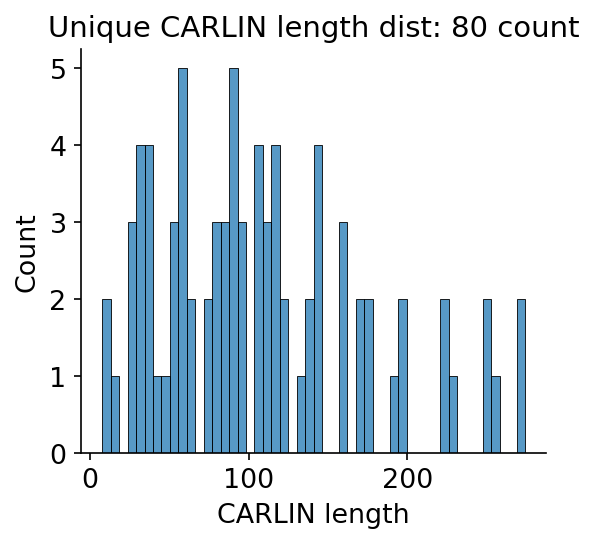

In [37]:
df_filter_reads['bc_length']=df_filter_reads['clone_id'].apply(lambda x: len(x))
unique_bc_length=list(set(df_filter_reads['bc_length']))
ax=sns.histplot(unique_bc_length,bins=50)
ax.set_xlabel('CARLIN length')
ax.set_title(f'Unique CARLIN length dist: {len(unique_bc_length)} count')

Denoise the clone id per each clone barcode length

We first perform barcode cleaning within a certian distance, then re-calculate the read number, and filter out low-read-count sequences. The read threshold is determined as the 10% of the max read count within each sequence length group, with a lower bound at min_reads_per_allele_group

## Collapse clone_id and filter cells within the same clone_id length

In [94]:
read_cutoff=3 # initial read count filtering 
# min_reads_per_allele_group=5 # the lower bound of the later read count filtering, after denoising, and re-group reads. 
# distance_relative_threshold=0.05 # 5% error rate, will be multipled with the sequence length
    
df_list=[]
unique_seq_length=list(set(df_filter_reads['bc_length']))
for target_length in sorted(unique_seq_length):
    df_tmp=df_filter_reads[df_filter_reads['bc_length']==target_length]#.groupby(['cell_bc','clone_id']).agg({'read':'sum'})
    df_HQ=larry.denoise_clonal_data(df_tmp,
        target_key="clone_id",
        read_cutoff=read_cutoff,
        denoise_method="UMI_tools",  # UMI_tools, 'Hamming'
        distance_threshold=1, #np.max([1,int(target_length*distance_relative_threshold)]),  
        whiteList=None,
        plot_report=False,
        progress_bar=False)

    df_HQ_group=larry.group_cells(df_HQ,group_keys=["library","cell_id","cell_bc","clone_id"])
    df_HQ_group['bc_length']=target_length
    df_list.append(df_HQ_group)
df_denoise_bc_0=pd.concat(df_list)

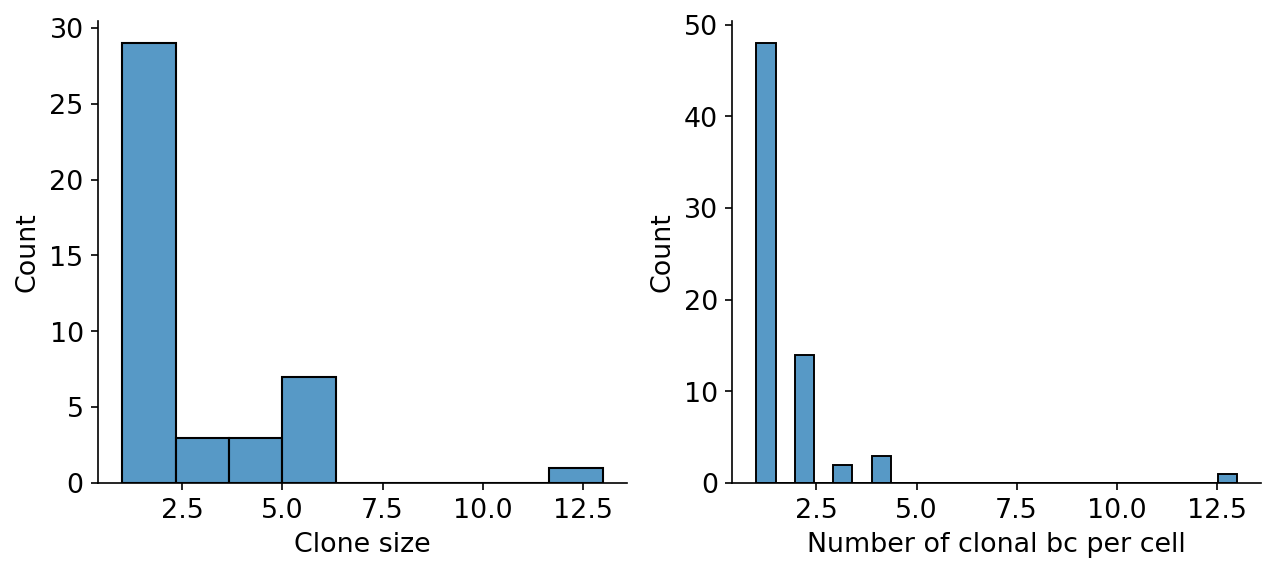

In [96]:
larry.QC_clonal_reports(df_denoise_bc_0)

In [97]:
larry.print_statistics(df_denoise_bc_0)

library number: 1
cell_id number: 68
clone_id number: 43
total reads: 31K


In [165]:
# use a low-filtering threshold, and also avoid filtering out valid_cell ids from above
def filter_low_read_cells_per_clone(df):
    coarse_grained_readcutoff=np.max([min_reads_per_allele_group,0.01*df['read'].max()])
    #return df[(df['read']>=coarse_grained_readcutoff) | df['cell_id'].isin(df_valid_cells['cell_id'].unique())]
    return df[(df['read']>=coarse_grained_readcutoff) ]

df_denoise_bc_1=df_denoise_bc_0.groupby('clone_id',group_keys=True).apply(filter_low_read_cells_per_clone).reset_index(drop=True)
#df_out=df_HQ_group
    

In [166]:
larry.print_statistics(df_denoise_bc_1)

library number: 1
cell_id number: 58
clone_id number: 43
total reads: 30K


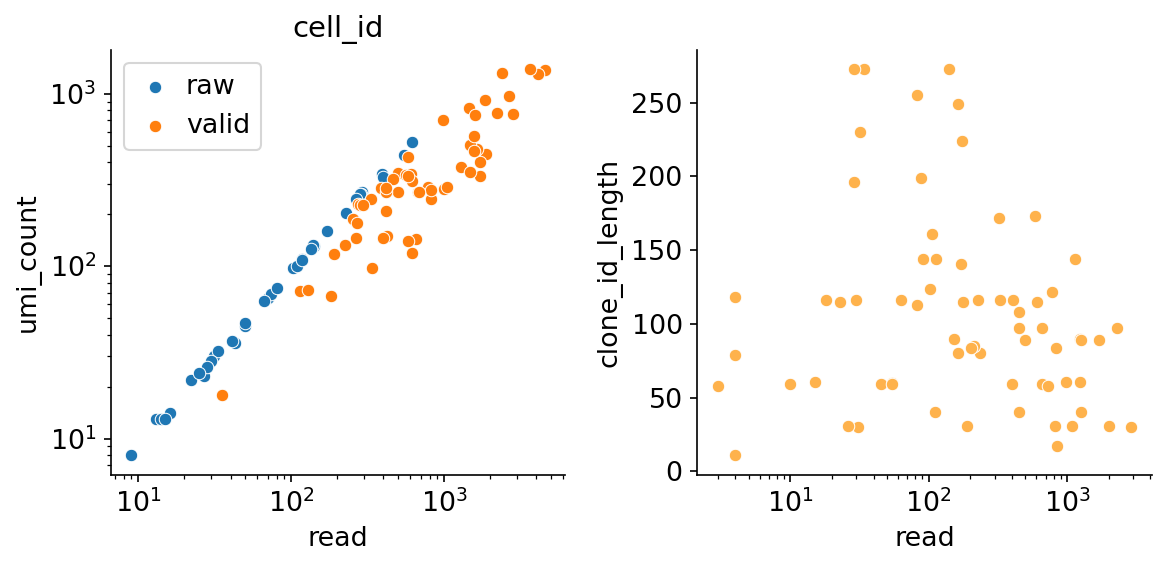

In [100]:
larry.QC_report_for_inferred_clones(df_filter_reads,df_denoise_bc_1)

## Select dominant clone_id within each cell_id

The above operation leaves some cell barcodes to have multiple clone barcodes. We select the read-dominant clonal barcodes as the putative clone id for each cell barcode.

In [155]:
# Obtain the dominant barcode in each cell
df_denoise_bc_2=larry.calculate_read_fraction_per_clone_cell(df_denoise_bc_1,norm_mode='max') # norm_mode: 'max', or 'sum'
df_final=df_denoise_bc_2[df_denoise_bc_2['cell_read_fraction']>0.99]

<Axes: xlabel='cell_read_fraction', ylabel='clone_read_fraction'>

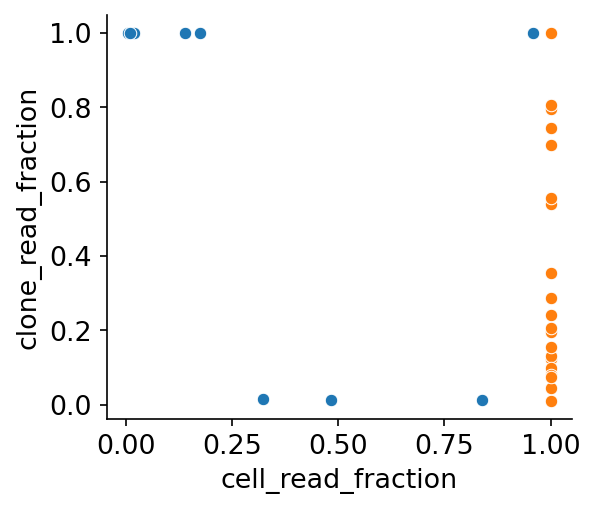

In [156]:
sns.scatterplot(data=df_denoise_bc_2,x='cell_read_fraction',y='clone_read_fraction')
sns.scatterplot(data=df_final,x='cell_read_fraction',y='clone_read_fraction')
#sns.scatterplot(data=df_output.merge(df_final,on=['cell_id','clone_id']),x='cell_read_fraction',y='clone_read_fraction',color='orange')
# plt.yscale('log')
# plt.xscale('log')

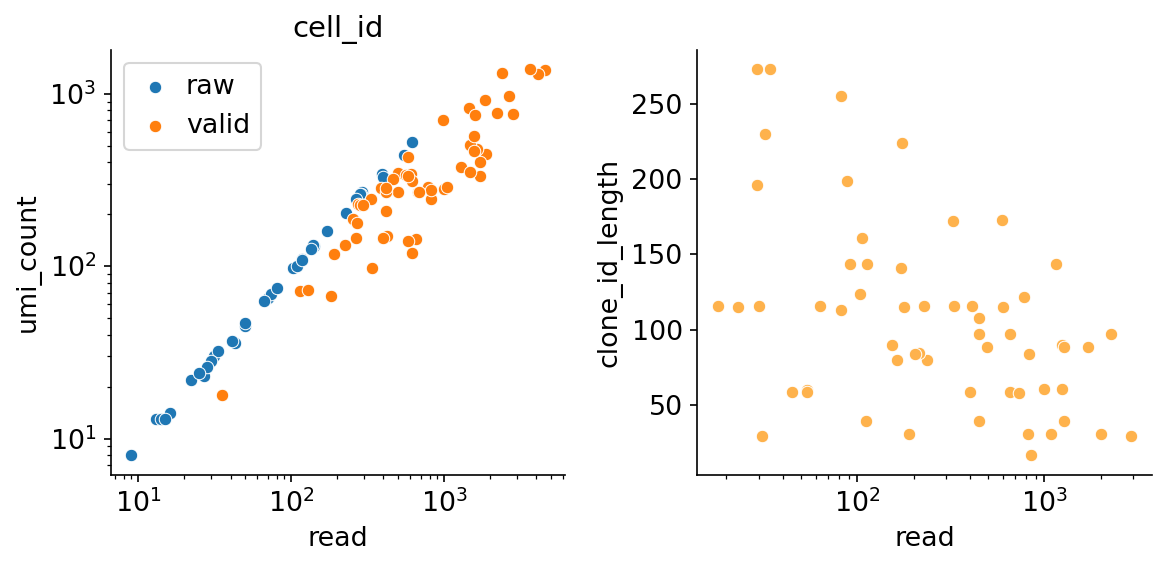

In [157]:
larry.QC_report_for_inferred_clones(df_filter_reads,df_final)

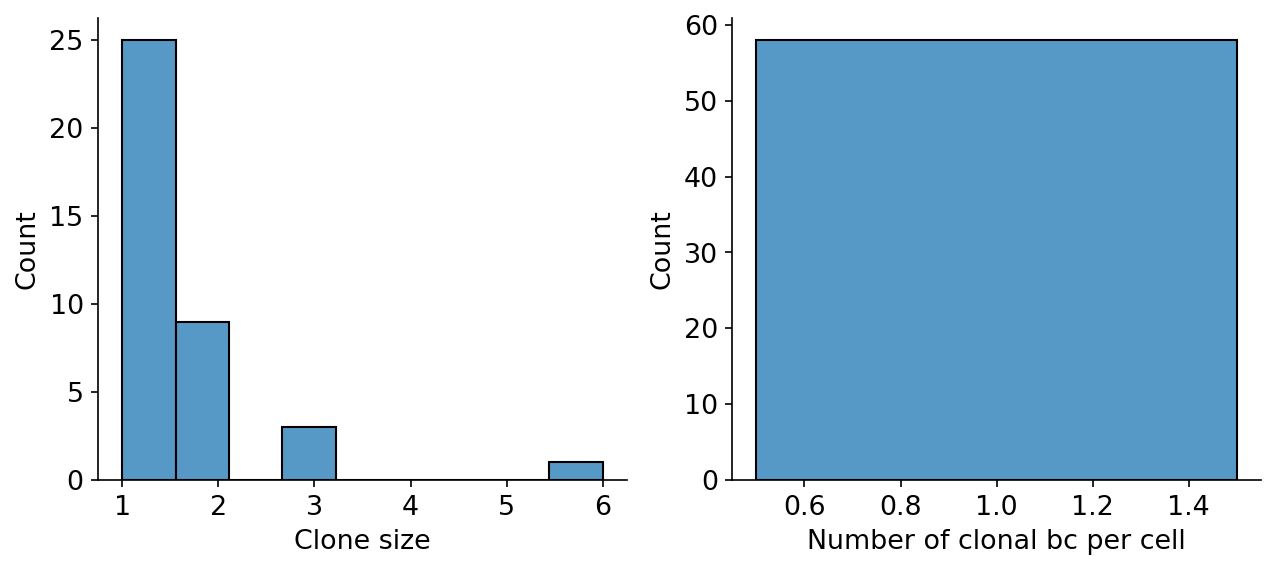

In [158]:
larry.QC_clonal_reports(df_final)

In [159]:
larry.print_statistics(df_final)

library number: 1
cell_id number: 58
clone_id number: 38
total reads: 30K


In [160]:
df_final.sort_values('bc_length')

,library,cell_id,cell_bc,clone_id,read,umi_count,bc_length,clone_id_length,total_read_per_cell,total_read_per_clone,cell_read_fraction,clone_read_fraction
65,LL731-P2-TC,LL731-P2-TC_ACGTATCA,ACGTATCA,TCGCCGGATACTATGGA,854,12,17,17,854,854,1.0,1.000000
19,LL731-P2-TC,LL731-P2-TC_CGACTGGA,CGACTGGA,TCGCCGGAGTCGAGACGCTGACGCTATGGA,31,3,30,30,31,2921,1.0,0.010613
20,LL731-P2-TC,LL731-P2-TC_CAACCACA,CAACCACA,TCGCCGGAGTCGAGACGCTGACGCTATGGA,2921,112,30,30,2921,2921,1.0,1.000000
25,LL731-P2-TC,LL731-P2-TC_ATTGGCTC,ATTGGCTC,TCGCCGGAGTCGAGACGCTGAGAAATATGGA,190,12,31,31,190,2002,1.0,0.094905
26,LL731-P2-TC,LL731-P2-TC_GGTGCGAA,GGTGCGAA,TCGCCGGAGTCGAGACGCTGAGAAATATGGA,2002,131,31,31,2002,2002,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
36,LL731-P2-TC,LL731-P2-TC_ACAAGCTA,ACAAGCTA,TCGCCGGAGTCGAGACGCTGACGATATGGAGTCGACACGACTCGCG...,174,4,224,224,174,174,1.0,1.000000
40,LL731-P2-TC,LL731-P2-TC_CCATCCTC,CCATCCTC,TCGCCGGAGTCGAGACGCTGACGCATATGGAGTCGACACGACTCGC...,32,3,230,230,32,32,1.0,1.000000
6,LL731-P2-TC,LL731-P2-TC_AGATCGCA,AGATCGCA,TCGCCGGAGTCGAGACGCTGACGAATATGGAGTCGACACGACTCGC...,82,3,255,255,82,82,1.0,1.000000
32,LL731-P2-TC,LL731-P2-TC_GATAGACA,GATAGACA,TCGCCGGAGTCGAGACGCTGACGATATGGAGTCGACACGACTCGCG...,29,1,273,273,29,141,1.0,0.205674


In [161]:
df_final=dar.check_editing(df_final,template)
print('Editing efficiency:', df_final['edited'].mean())

Editing efficiency: 0.9655172413793104


In [162]:
df_final.to_csv(f'{output_dir}/called_barcodes_by_SW_method.csv',index=0)
df_filter_reads.to_csv(f'{output_dir}/df_filter_reads_by_SW_method.csv',index=0)

In [163]:
# df_plot=df_filter_reads[df_filter_reads['clone_id'].isin(df_final['clone_id'].unique())]
# sns.histplot(df_plot['read'],log_scale=True)

## Compare with CARLIN pipeline

In [164]:
compare_with_CARLIN_pipeline=False
if compare_with_CARLIN_pipeline:
    df_ref=dar.extract_CARLIN_info(CARLIN_dir,[sample])
    
    us_unique=set(df_final['clone_id'])
    orig_pipeline_unique=set(df_ref['CARLIN'])
    BC_insersect=us_unique.intersection(orig_pipeline_unique)
    print(f'Dected unique clones by our method: {len(us_unique)}; by CARLIN pipeline: {len(orig_pipeline_unique)}; intersection: {len(BC_insersect)}')
    
    df_ref_flat=dar.CARLIN_output_to_cell_by_barcode_long_table(df_ref)
    df_ref_flat_new=df_ref_flat.merge(df_filter_reads,on=['cell_bc','clone_id']).groupby(
            ['cell_id','cell_bc','clone_id']).agg(read=('read','sum'),CARLIN_length=('bc_length','mean')).reset_index()
    df_ref_flat_new['method']='CARLIN_pipeline'
    
    df_joint=df_final.merge(df_ref_flat_new,on=['cell_id','cell_bc','clone_id'],how='inner').set_index('cell_id')
    df_ref_flat_new=df_ref_flat_new.set_index('cell_id')
    df_ref_flat_new.loc[df_joint.index,'read']=df_joint['read_x']
    df_ref_flat_new=df_ref_flat_new.reset_index()
    
    plt.subplots()
    plt.plot(df_final['read'],df_final['CARLIN_length'],'^b',label='Our method')
    plt.plot(df_ref_flat_new['read'],df_ref_flat_new['CARLIN_length'],'+r',label='CARLIN')
    plt.xscale('log')
    plt.legend()
    plt.xlabel('read number')
    plt.ylabel('CARLIN sequence length')
    
    plt.subplots()
    df_plot=df_filter_reads.groupby(['cell_id']).agg(read=('read','sum'),umi_count=('umi',lambda x: len(set(x)))).reset_index()
    plt.plot(df_plot['read'],df_plot['umi_count'],'.',color='grey')
    df_tmp=df_plot[df_plot['cell_id'].isin(df_final['cell_id'])]
    plt.plot(df_tmp['read'],df_tmp['umi_count'],'^b',label='Our method')
    df_tmp=df_plot[df_plot['cell_id'].isin(df_ref_flat_new['cell_id'])]
    plt.plot(df_tmp['read'],df_tmp['umi_count'],'+r',label='CARLIN')
    #sns.scatterplot(data=df_plot[df_plot['cell_id'].isin(df_ref_flat_new['cell_id'])],x='read',y='umi_count')
    #plt.plot([2*10**2,10**4],[2*10**2,0.6*10**4])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Read number')
    plt.ylabel('UMI count')
    plt.legend()
    
    df_final['method']='SW'
    df_outer_joint=df_final.merge(df_ref_flat_new.drop(['read','CARLIN_length'],axis=1),on=['cell_id','cell_bc','clone_id'],
                   how='outer').sort_values('CARLIN_length')
    only_df_ref=df_ref_flat_new[df_ref_flat_new.cell_id.isin(df_outer_joint[pd.isna(df_outer_joint['library'])]['cell_id'])].set_index('cell_id')
    df_outer_joint=df_outer_joint.set_index('cell_id')
    for x in ['CARLIN_length','read']:
        df_outer_joint.loc[only_df_ref.index,x]=only_df_ref[x]
    df_outer_joint=df_outer_joint.reset_index()
    print(df_outer_joint)
    
    df_outer_joint.to_csv(f'{output_dir}/df_outer_joint.csv',index=0)
    
    SW_cells=set(df_outer_joint[df_outer_joint['method_x']=='SW']['cell_id'].to_list())
    CARLIN_cells=set(df_outer_joint[df_outer_joint['method_y']=='CARLIN_pipeline']['cell_id'].to_list())
    cells_insersect=SW_cells.intersection(CARLIN_cells)
    print(f'Dected unique cells by our method: {len(SW_cells)}; by CARLIN pipeline: {len(CARLIN_cells)}; intersection: {len(cells_insersect)}')